## dataset.ipynb: preprocess the dataset 

In [1]:
# Import the necessary libraries
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import os
import random
from random import shuffle
# from skimage.transform import rotate
import scipy.ndimage
from spectral import *

In [2]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features(dimensions)  n
numComponents = 30
# Patches windows size
windowSize = 5
# The proportion of Test sets
testRatio = 0.80

In [3]:
#  load the Indian pines dataset which is the .mat format
def loadIndianPinesData():
    data_path = 'E:\Eric_HSI\hyperspectral_datasets'
    data = sio.loadmat(os.path.join(data_path, 
                      'Indian_pines_corrected.mat'))['data']
    labels = sio.loadmat(os.path.join(data_path, 
                        'Indian_pines_gt.mat'))['groundT']
    
    return data, labels

In [4]:
X, y = loadIndianPinesData()
uniqueLabels, labelCounts = np.unique(y, return_counts=True)
X.shape, y.shape, uniqueLabels, labelCounts

((145, 145, 200),
 (145, 145),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=uint8),
 array([10776,    46,  1428,   830,   237,   483,   730,    28,   478,
           20,   972,  2455,   593,   205,  1265,   386,    93],
       dtype=int64))

In [5]:
#  load the Indian pines dataset which is HSI format
#  refered from http://www.spectralpython.net/fileio.html
def loadHSIData():
    data_path = os.path.join(os.getcwd(), 'HSI_data')
    data = open_image(os.path.join(data_path, '92AV3C.lan')).load()
    data = np.array(data).astype(np.int32)
    labels = open_image(os.path.join(data_path, '92AV3GT.GIS')).load()
    labels = np.array(labels).astype(np.uint8)
    labels.shape = (145, 145)
    return data, labels

In [6]:
#  apply PCA preprocessing for data sets
# print(X.shape)  # (145, 145, 30)
# print(y.shape) # (145, 145)

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
# X, pca = applyPCA(X, numComponents=numComponents)
# X.shape, pca

In [8]:
#  pad zeros to dataset

# X (145, 145, 30)
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

In [9]:
# newX = padWithZeros(X, margin=2)
# newX.shape   # (149, 149, 30)

In [10]:
#  create Patches for dataset 顾名思义，将一整张图片划分成一个个小的patch。TotalPatNum，width，height，channels。((10366, 5, 5, 30), (10366,))
# 老实说，这段代码，我不是很能理解。。。希望有大神带带我

# Patches windows size
# windowSize = 5
# X (145, 145, 30)
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)                                         # =>2
    zeroPaddedX = padWithZeros(X, margin=margin)             # (149, 149, 30)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, 
                            windowSize, X.shape[2]))                                                   # (21025, 5, 5, 30)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))                         # (21025,)
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
            
    # 删除像素值为零的值
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0, : , : , :]                     # ((10366, 5, 5, 30)
        patchesLabels = patchesLabels[patchesLabels>0]                         # (10366,))
        patchesLabels -= 1
    return patchesData, patchesLabels

In [11]:
# XPatches, yPatches = createPatches(X, y, windowSize=windowSize) 
# print(XPatches.shape, yPatches.shape)

In [12]:
#  split data to Train and Test Set
# print(X.shape)  # (145, 145, 220)
# print(y.shape) # (145, 145)
# X： ((10366, 5, 5, 30)
# y：(10366,))
# X_train:  ((5183, 5, 5, 30), y_train : ((5183,)
# X_test : (5183, 5, 5, 30)), y_test ： (5183,)

def splitTrainTestSet(X, y, classnum=15, testRatio=0.80):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                test_size=testRatio, random_state=345, stratify=y)
    ss=StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio, 
                              train_size=1-testRatio, random_state=0)
    
    for train_index, test_index in ss.split(X, y):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return X_train, X_test, y_train, y_test

In [13]:
# X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches,        
#                                                      y.max()-y.min(), testRatio)

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [14]:
#  over sample 
# 过采样，将比例比较少的例子重复几次，然后叠加到原始数据上
# X_train:  ((5183, 5, 5, 30), y_train : ((5183,)
# 变为
# X_train : ((20110, 5, 5, 30), y_train : (20110,))

def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), 
                                                   axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [15]:
# X_train, y_train = oversampleWeakClasses(X_train, y_train)
# X_train.shape, y_train.shape

In [16]:
#  standartize
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[3]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], X.shape[2], X.shape[3]))
    return newX, scaler

In [17]:
# X_train, scaler = standartizeData(X_train)
# X_train.shape, scaler

In [18]:
#  Augment Data
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, 
                            no,axes=(1, 0), reshape=False, output=None, 
                            order=3, mode='constant', cval=0.0, prefilter=False)
        
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [19]:
# X_train = AugmentData(X_train)
# X_train.shape

In [20]:
# save Preprocessed Data to file
def savePreprocessedData(path, X_trainPatches, X_testPatches, y_trainPatches, 
                         y_testPatches, X_all, y_all, windowSize, wasPCAapplied = False, 
                         numPCAComponents = 0, testRatio = 0.25):
    
    data_path = os.path.join(os.getcwd(), path)

    if wasPCAapplied:
        with open(os.path.join(data_path, "X_train_WS_") + str(windowSize) + 
                  "_PCA_" + str(numPCAComponents) + "_testRatio_" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join(data_path, "X_test_WS_") + str(windowSize) + 
                  "_PCA_" + str(numPCAComponents) + "_testRatio_" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join(data_path, "y_train_WS_") + str(windowSize) + 
                  "_PCA_" + str(numPCAComponents) + "_testRatio_" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join(data_path, "y_test_WS_") + str(windowSize) + 
                  "_PCA_" + str(numPCAComponents) + "_testRatio_" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
        
        with open(os.path.join(data_path, "X_All_WS_") + str(windowSize) + 
                  "_PCA_" + str(numPCAComponents) + "_testRatio_" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_all)
        with open(os.path.join(data_path, "y_All_WS_") + str(windowSize) + 
                  "_PCA_" + str(numPCAComponents) + "_testRatio_" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_all)
    else:
        with open(os.path.join(data_path, "preXtrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join(data_path, "preXtestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join(data_path, "preytrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join(data_path, "preytestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
            

In [21]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features(dimensions)  n
numComponents = 30
# Patches windows size
windowSize = 5
# The proportion of Test sets
testRatio = 0.80

In [22]:
# Load dataset from file and apply PCA
# X, y = loadHSIData()

# print(X.shape)  # (145, 145, 220)
# print(y.shape) # (145, 145)
X, y = loadIndianPinesData()
X, pca = applyPCA(X, numComponents=numComponents)
# print(X.shape)  # (145, 145, 30)

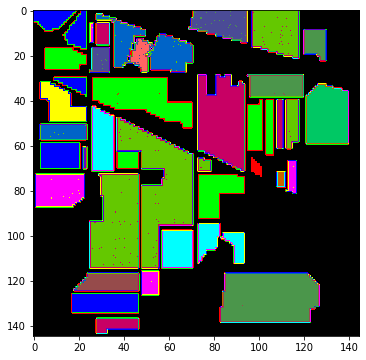

In [23]:
ground_truth = imshow(classes=y, figsize=(6, 6))

In [24]:
# np.append(arr, values, axis=0)  
# arr，values都将先展平成一维数组,然后沿着axis=0的方向在arr后添加values

In [25]:
# Preprocess Data
XPatches, yPatches = createPatches(X, y, windowSize=windowSize) 
# print(XPatches.shape, yPatches.shape)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches,        
                                                     y.max()-y.min(), testRatio)

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_all = np.append(X_train, X_test, axis=0)                    # (10366, 5, 5, 30)
y_all = np.append(y_train, y_test, axis=0)                     # (10366,)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
X_train, scaler = standartizeData(X_train)
# print(X_train.shape, y_train.shape)
# # X_all, y_all = oversampleWeakClasses(X_all, y_all)
X_train = AugmentData(X_train)
print(X_train.shape)
# # X_all = AugmentData(X_all)

(7919, 5, 5, 30)


In [26]:
# save Preprocessed Data to file
savePreprocessedData('predata', X_train, X_test, y_train, y_test, 
                     X_all, y_all, windowSize = windowSize, 
                     wasPCAapplied=True, numPCAComponents = numComponents, 
                     testRatio = testRatio)